# Optimizing a TF (VGG16) model using SageMaker Neo

SageMaker NEO (https://aws.amazon.com/sagemaker/neo/) is a feature of SageMaker that you can use to optimize a trained model for best performance. It's an OpenSource project based on TVM and Treelite.

https://github.com/neo-ai

It combines a set of optmiziation techniques to reduce the model size, merging operators, etc.

In order to use SageMaker Neo you take a look at this page: https://docs.aws.amazon.com/sagemaker/latest/dg/neo-troubleshooting.html. See the supported operators and then you can build your model following these orientations. After that you can use HyperParameter optimization and other strategies to train your model. So, you can then create a Compilation Job to optimize the trained model yet more.

The assests generated by SageMaker Neo is an intermediate model. It means that you don't need the original framework (used to create your model) anymore. Now you need to use DLR (https://github.com/neo-ai/neo-ai-dlr). A light runtime that will interpret the optimized model in the target device (CPU or GPU). Just install DLR into your device and do predictions!

##### In this exercise we'll create use the VGG16 implementation of part 1 and train a model. Later, we'll optimize that model with SageMaker NEO

## 1) Training/Optimizing the model
### (skip this whole session if you opted per a pretrained model)
### 1.1) Now, let's train our model with the whole Dataset 


In [2]:
import sagemaker
import time

from sagemaker.tensorflow import TensorFlow

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'caltech256'

role = sagemaker.get_execution_role()

In [4]:
!ls src/

caltech256_vgg16.py  __pycache__  vgg16.py


In [5]:
local = False
source_dir = 'src'
model_dir = '/opt/ml/model'
train_instance_type = 'local_gpu' if local else 'ml.p3.2xlarge'
job_prefix='tf-caltech256-vgg16'

hyperparameters = {
    'epochs': 20, 
    'batch_size': 8,
    'num_classes': 257,
    'learning_rate': 0.00003
}
metric_definitions=[
   {'Name': 'train:accuracy', 'Regex': 'train_acc=(.*?);' },
   {'Name': 'validation:accuracy', 'Regex': 'val_acc=(.*?);' },
   {'Name': 'train:loss', 'Regex': 'train_loss=(.*?);' },
   {'Name': 'validation:loss', 'Regex': 'val_loss=(.*?);' }
]
estimator = TensorFlow(entry_point='caltech256_vgg16.py',
                       model_dir=model_dir,
                       source_dir=source_dir,
                       train_instance_type=train_instance_type,
                       train_instance_count=1,
                       hyperparameters=hyperparameters,
                       role=role,
                       base_job_name=job_prefix,
                       framework_version='1.11.0',
                       metric_definitions=metric_definitions,
                       ## Uncomment the following lines for using Spot Instances
                       #train_use_spot_instances=True,
                       #train_max_run=100*60*60,
                       #train_max_wait=100*60*60,
                       py_version='py3',
                       script_mode=True)

In [6]:
if local:
    pwd=!pwd
    train_dir='{}/dataset/sample/train'.format(pwd[0])
    test_dir='{}/dataset/sample/test'.format(pwd[0])
    inputs = {'train': f'file://{train_dir}',
              'test': f'file://{test_dir}'}
else:
    inputs = {'train': 's3://%s/%s/train' % (bucket, prefix),
             'test': 's3://%s/%s/test' % (bucket, prefix)}
estimator.fit(inputs, wait=False)

### 1.2) After finish training, we can now start a new Optimization Job with SageMaker NEO

In [27]:
target_device='ml_m4'  #'ml_m4'|'ml_m5'|'ml_c4'|'ml_c5'|'ml_p2'|'ml_p3'|'jetson_tx1'|'jetson_tx2'|'rasp3b'|'deeplens'
optimized_estimator = estimator.compile_model(
    target_instance_family = target_device, 
    input_shape = '{"data":[1,224,224,3]}', 
    output_path="s3://%s/%s/optimized" % (bucket, prefix),
    framework='tensorflow', 
    framework_version='1.11.0', 
    compile_max_run=300
)

?..............!

### 1.3) Ok. Now let's download both trained/optmized modules to test them locally

In [32]:
!aws s3 cp $estimator.model_data .
!aws s3 cp $optimized_estimator.model_data .

targz_file='model-%s.tar.gz' % target_device

!rm -rf model && mkdir model
!tar -xzvf model.tar.gz -C model
!tar -xzvf $targz_file -C model

!rm -f $estimator.model_data $optimized_estimator.model_data

download: s3://sagemaker-us-east-1-715445047862/tf-caltech256-vgg16-2019-09-09-13-52-32-326/output/model.tar.gz to ./model.tar.gz
download: s3://sagemaker-us-east-1-715445047862/caltech256/optimized/model-ml_m4.tar.gz to ./model-ml_m4.tar.gz
0001/frozen_model.pb
compiled.params
compiled_model.json
compiled.so


## 2) Use a pre-trained model instead
### (skip this session if you already executed session 1)
If you skiped Session 1 you probably want a pre-trained model.

It makes sense if you don't have access to a P3 instance or don't want to spend ~1h/P3 training a yet another VGG16 vs caltech256

In [22]:
!aws s3 cp s3://spock.cloud/ai-workshop/tf_vgg16_caltech256/model.tar.gz .
!tar -xzvf model.tar.gz -C model/

download: s3://spock.cloud/ai-workshop/tf_vgg16_caltech256/model.tar.gz to ./model.tar.gz
0001/
0001/frozen_model.pb


In [15]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [23]:
base_prefix = 'caltech256'
prefix=base_prefix + '/model'
inputs = sagemaker_session.upload_data(path='model.tar.gz', bucket=bucket, key_prefix=prefix)
!rm -f model.tar.gz

In [35]:
import boto3
import time

job_name="%s-%d" % ('tf-caltech256-vgg16', int(time.time()))
target_device='ml_m4'
model_file='model-%s.tar.gz' % target_device
sm = boto3.client( 'sagemaker')
# 'lambda'|'ml_m4'|'ml_m5'|'ml_c4'|'ml_c5'|'ml_p2'|'ml_p3'|'jetson_tx1'|'jetson_tx2'|'jetson_nano'
#|'rasp3b'|'deeplens'|'rk3399'|'rk3288'|'aisage'|'sbe_c'|'qcs605'|'qcs603'
resp = sm.create_compilation_job(
    CompilationJobName=job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': inputs,
        'DataInputConfig': '{"data":[1,224,224,3]}',
        'Framework': 'TENSORFLOW'
    },
    OutputConfig={
        'S3OutputLocation': 's3://%s/%s/optimized' % (bucket, base_prefix),
        'TargetDevice': target_device
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': 300,
        'MaxWaitTimeInSeconds': 300
    }
)
while True:
    resp = sm.describe_compilation_job(
        CompilationJobName=job_name
    )
    if resp['CompilationJobStatus'] == 'COMPLETED':
        model_path=resp['ModelArtifacts']['S3ModelArtifacts']
        !aws s3 cp $model_path .
        !tar -xzvf $model_file -C model/
        break
    elif resp['CompilationJobStatus'] not in ['INPROGRESS', 'STARTING']:
        print("Error")
        break
    time.sleep(10)
    print("Optimizing")

Optimizing
Optimizing
Optimizing
Optimizing
Optimizing
Optimizing
Optimizing
Optimizing
Optimizing
download: s3://sagemaker-us-east-1-715445047862/caltech256/optimized/model-ml_m4.tar.gz to ./model-ml_m4.tar.gz
compiled.params
compiled_model.json
compiled.so


## 3) Let's play a little with our optmized model

In [1]:
# !pip install -U --force-reinstall dlr
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from importlib import reload
from dlr import DLRModel
import glob
import random
import numpy as np
import sys
sys.path.insert(0,'src')
import src.caltech256_vgg16 as c
c = reload(c)

all_image_paths = list(glob.glob('256_ObjectCategories/*/*.jpg'))
labels = {}
for i in all_image_paths:
    _,cat,fname = i.split('/')
    cat_id, cat_name = cat.split('.')
    cat_id = int(cat_id)-1
    labels[cat_id] = cat_name

x_sample = np.load('dataset/sample/train/x_train.npy')

neo_model = DLRModel('model', dev_type='cpu')
tfl_model = c.model_fn('model')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/a

In [12]:
!ls -lat model/0001/

total 528596
drwxrwxr-x 3 ec2-user ec2-user      4096 Sep  9 20:15 ..
drwxr-xr-x 2 ec2-user ec2-user      4096 Sep  9 18:49 .
-rw-r--r-- 1 ec2-user ec2-user 541267788 Sep  9 18:49 frozen_model.pb


In [2]:
%time
import matplotlib.pyplot as plt

image = x_sample[random.randint(0, len(x_sample))]
payload = np.expand_dims( image, axis=0 )

input_data = {'Placeholder': payload}
out = neo_model.run( input_data )[0][0]

index = np.argmax(out)
probs = out[index]
image = (image + [123.68, 116.779, 103.939]).astype(np.uint8)
print("Class id: {} Probs: {} Label: {}".format(index, probs, labels[index]))
plt.imshow(image)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
Class id: 137 Probs: 0.999082088470459 Label: mattress


## 4) Then, let's do some predictions and compute the times

In [3]:
import numpy as np
import time

payload = np.expand_dims( x_sample[0], axis=0 )
input_data = {'Placeholder': payload}

max_tries = 10
elapsed_time = np.zeros((2, max_tries), dtype=np.float32)
for i in range(max_tries):
    print("Iteration %d" % i)
    start_time = time.time()
    c.predict_fn(payload, tfl_model)
    elapsed_time[0][i] = time.time() - start_time
    
    start_time = time.time()
    neo_model.run(input_data)
    elapsed_time[1][i] = time.time() - start_time

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


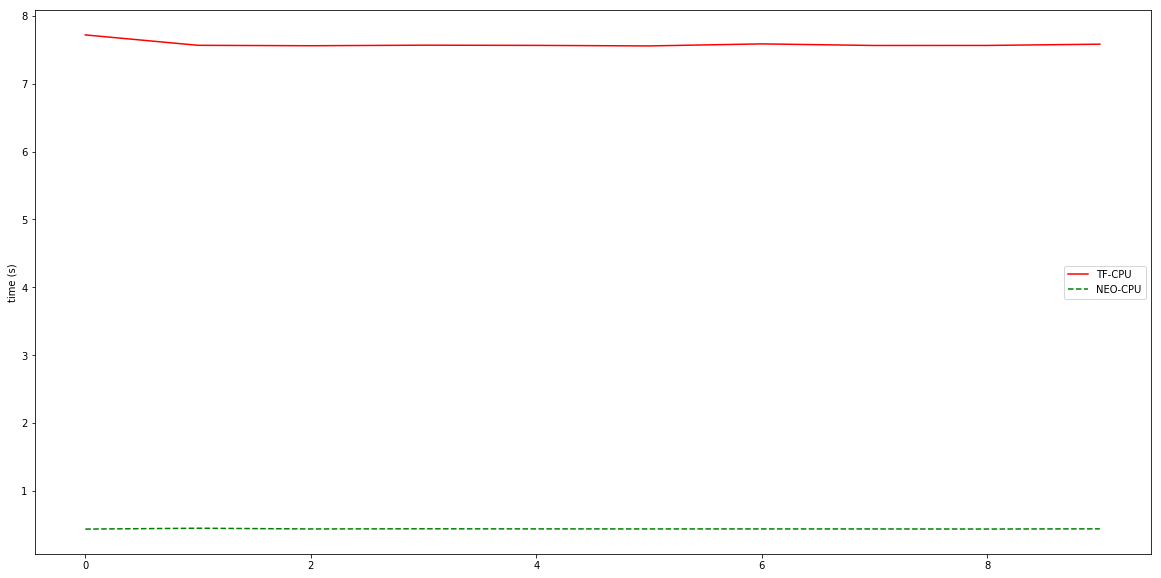

In [4]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1)
plt.ylabel('time (s)')
ax.set_prop_cycle(color=['red', 'green'])
ax.plot(elapsed_time[0], '-',label='TF-CPU')
ax.plot(elapsed_time[1], '--', label='NEO-CPU')
ax.legend()